<a href="https://colab.research.google.com/github/pkrishna1801/Sentiment-analysis-using-Roberta/blob/main/Fine_tuning_RoBERTa_Unhealthy_Comment_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!nvidia-smi

Sun Mar 23 22:31:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   72C    P0             34W /   72W |     243MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [74]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install transformers
%pip install pytorch-lightning
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard


Looking in indexes: https://download.pytorch.org/whl/cu121


In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import (
    AutoModel,
    AutoTokenizer,
    get_cosine_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from typing import Optional, Dict, List

# Check versions and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1


In [76]:
train_path = '/content/train.csv'
val_path = '/content/val.csv'

In [77]:
train_data = pd.read_csv(train_path)

In [78]:
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


# inspect data

<Axes: >

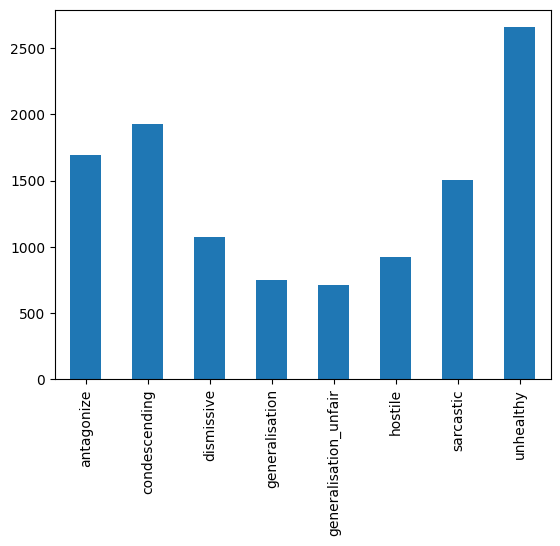

In [79]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)

attributes = ['antagonize', 'condescending','dismissive','generalisation',
              'generalisation_unfair','hostile','sarcastic','unhealthy']

train_data[attributes].sum().plot.bar()

# Dataset

In [119]:
class UCCDataset(Dataset):
    """Dataset class for Unhealthy Comment Corpus (UCC)

    Args:
        data_path (str): Path to the CSV data file
        tokenizer: HuggingFace tokenizer
        attributes (List[str]): List of target attributes to predict
        max_token_len (int): Maximum token length for padding/truncation
        sample (Optional[int]): Number of samples to use (for balanced sampling)
    """
    def __init__(
        self,
        data_path: str,
        tokenizer,
        attributes: List[str],
        max_token_len: int = 128,
        sample: Optional[int] = 5000
    ):
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.data = self._prepare_data(data_path, sample)

    def _prepare_data(self, data_path: str, sample: Optional[int]) -> pd.DataFrame:
        data = pd.read_csv(data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)

        # Convert all attribute columns to float type
        for attr in self.attributes:
            data[attr] = data[attr].astype(float)

        if sample:
            unhealthy = data[data[self.attributes].sum(axis=1) > 0]
            clean = data[data[self.attributes].sum(axis=1) == 0]
            return pd.concat([
                unhealthy,
                clean.sample(sample, random_state=42)
            ]).reset_index(drop=True)
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        row = self.data.iloc[index]

        # Encode text
        encoding = self.tokenizer(
            str(row.comment),
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Get labels and ensure they are float type
        labels = torch.tensor(
            self.data.iloc[index][self.attributes].values.astype(float),
            dtype=torch.float
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

In [120]:
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# ucc_ds = UCCDataset(train_path, tokenizer, attributes=attributes, max_token_len=128)
ucc_ds = UCCDataset(train_path, tokenizer, attributes=attributes, max_token_len=128, sample=None)
ucc_ds_val = UCCDataset(val_path, tokenizer, attributes=attributes, max_token_len=128, sample=None)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [121]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 15622, 21304,     6,   484, 19117,  5788,     6, 17136,  4764,
             6,    98, 45676,   110,   477, 28749,   286,   103,    63,   373,
           301,   328,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [122]:
ucc_ds.__getitem__(0)['labels'].shape, ucc_ds.__getitem__(0)['input_ids'].shape, ucc_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([8]), torch.Size([128]), torch.Size([128]))

In [123]:
len(ucc_ds)

35503

In [124]:
len(ucc_ds_val)

4427

# Data module

In [125]:
class UCCDataModule(pl.LightningDataModule):
    """PyTorch Lightning DataModule for UCC dataset

    Args:
        train_path (str): Path to training data
        val_path (str): Path to validation data
        attributes (List[str]): Target attributes to predict
        batch_size (int): Batch size for training
        max_token_length (int): Maximum token length
        model_name (str): HuggingFace model name
        num_workers (int): Number of workers for DataLoader
    """
    def __init__(
        self,
        train_path: str,
        val_path: str,
        attributes: List[str],
        batch_size: int = 32,
        max_token_length: int = 128,
        model_name: str = 'roberta-base',
        num_workers: int = 4
    ):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage: Optional[str] = None):
        if stage in (None, "fit"):
            self.train_dataset = UCCDataset(
                self.train_path,
                self.tokenizer,
                self.attributes
            )
            self.val_dataset = UCCDataset(
                self.val_path,
                self.tokenizer,
                self.attributes,
                sample=None
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

In [126]:
ucc_data_module = UCCDataModule(
    train_path=train_path,
    val_path=val_path,
    attributes=attributes,
    batch_size=32,
    max_token_length=128,
    model_name='roberta-base',
    num_workers=4
)

In [127]:
ucc_data_module.setup()

In [128]:
ucc_data_module.train_dataloader()

In [129]:
# Number of batches (9960 // 16 = 623)
len(ucc_data_module.train_dataloader())

312

In [137]:
# prompt: import torchmetrics

# !pip install torchmetrics

import torchmetrics
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC


# Model

In [139]:
class UCCClassifier(pl.LightningModule):
    def __init__(self, config: Dict):
        super().__init__()
        self.save_hyperparameters(config)

        self.pretrained_model = AutoModel.from_pretrained(
            config['model_name'],
            return_dict=True
        )
        self.hidden = nn.Linear(
            self.pretrained_model.config.hidden_size,
            self.pretrained_model.config.hidden_size
        )
        self.classifier = nn.Linear(
            self.pretrained_model.config.hidden_size,
            config['n_labels']
        )
        self.dropout = nn.Dropout(p=0.1)
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Metrics
        self.accuracy = torchmetrics.classification.MultilabelAccuracy(config['n_labels'], threshold=0.5)
        self.pr_curve = torchmetrics.classification.MultilabelPrecisionRecallCurve(config['n_labels'])
        self.f1 = MultilabelF1Score(num_labels=config['n_labels'], threshold=0.5)
        self.auroc = MultilabelAUROC(num_labels=config['n_labels'])
        # Store predictions & labels across all epochs
        self.all_preds_list = []
        self.all_labels_list = []

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = torch.mean(outputs.last_hidden_state, 1)

        hidden_output = self.dropout(F.relu(self.hidden(pooled_output)))
        logits = self.classifier(hidden_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return loss, logits

    def training_step(self, batch):
        loss, _ = self(**batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch):
        loss, logits = self(**batch)

        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        # labels = batch["labels"].to(torch.int)  # Convert labels to int
        labels = batch["labels"].to(torch.int)


        acc = self.accuracy(preds > 0.5, labels > 0.5)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, logger=True)
        f1 = self.f1(preds, labels)
        auroc = self.auroc(preds, labels)

        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auroc", auroc, prog_bar=True)

        # Store predictions and labels for PR curve calculation
        self.all_preds_list.append(preds.detach().cpu())
        self.all_labels_list.append(labels.detach().cpu())

        return {"val_loss": loss, "val_acc": acc}

    def on_fit_end(self):
        """Compute and plot PR curve after all epochs."""
        if not self.all_preds_list:
            print("No validation data collected for PR curve.")
            return

        preds = torch.cat(self.all_preds_list, dim=0)
        labels = torch.cat(self.all_labels_list, dim=0)

        precisions, recalls, _ = self.pr_curve(preds, labels)
        self.plot_precision_recall_curve(precisions, recalls)


    def plot_precision_recall_curve(self, precisions, recalls):
        """Plot Precision-Recall curves for all classes."""
        num_classes = len(precisions)

        plt.figure(figsize=(10, 6))
        for i in range(num_classes):
            plt.plot(recalls[i].cpu().numpy(), precisions[i].cpu().numpy(), label=f'Class {i}')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves (After All Epochs)')
        plt.legend()
        plt.grid()
        plt.show()

    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(self.hparams.warmup * self.hparams.train_steps),
            num_training_steps=self.hparams.train_steps
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }


## Training setup

### Experiment with batch size =16

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                           | Params | Mode 
----------------------------------------------------------------------------
0 | pretrained_model | RobertaModel                   | 82.1 M | eval 
1 | hidden           | Linear                         | 590 K  | train
2 | classifier       | Linear                         | 6.2 K  | train
3 | dropout          | Dropout                        | 0      | train
4 | loss_fn          | BCEWithLo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

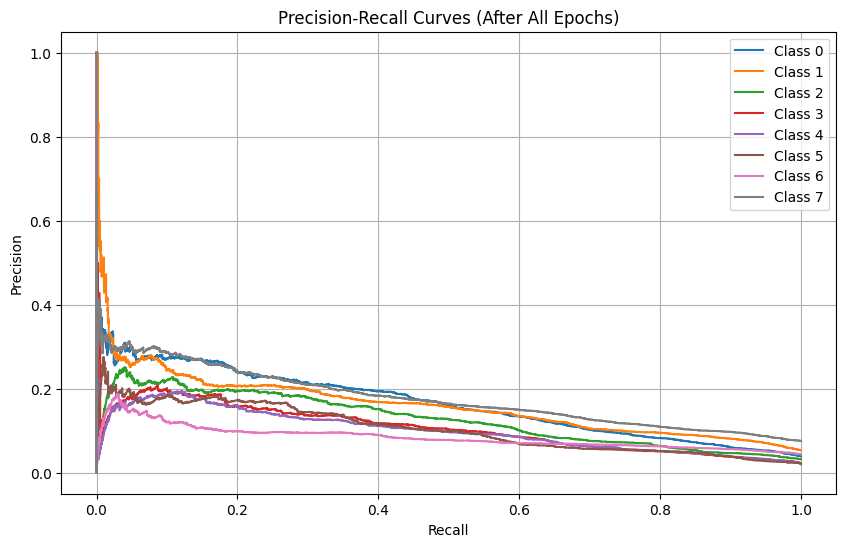

In [140]:
# Set environment variable to avoid tokenizer warnings
import os
from pytorch_lightning.loggers import CSVLogger
os.environ["TOKENIZERS_PARALLELISM"] = "false"
csv_logger = CSVLogger("logs/", name="ucc_classifier")

# Configuration
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 5e-6,
    'warmup': 0.1,
    'weight_decay': 0.01,
    'n_epochs': 10,
    'train_steps': len(ucc_data_module.train_dataloader()) * 5  # total steps for 5 epochs
}

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='ucc-roberta-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name="ucc_classifier")

# Trainer
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    accelerator='gpu',
    devices=1,  # Use single GPU
    callbacks=[checkpoint_callback, early_stopping],
    logger=[logger, csv_logger],
    gradient_clip_val=1.0,
    log_every_n_steps=10
)

# Model
model = UCCClassifier(config)

# Initialize the model's pooler weights from pretrained
# model.pretrained_model.init_weights()
# Train
trainer.fit(model, ucc_data_module)

# Predict with model

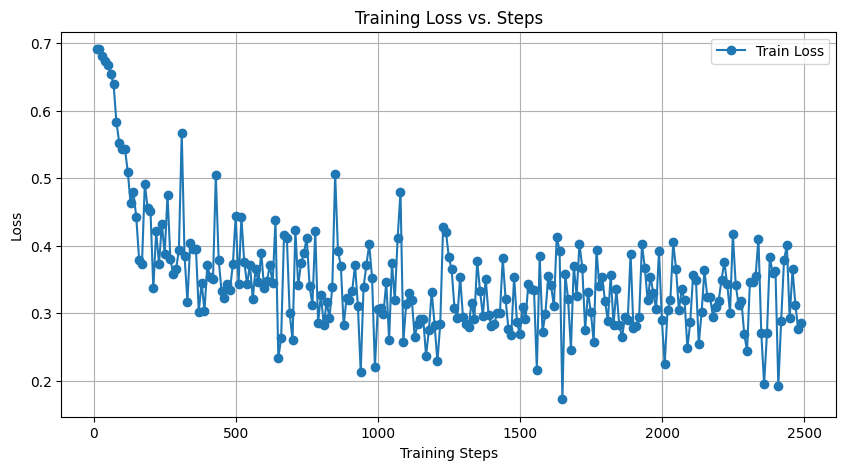

In [141]:
import pandas as pd

# Load the CSV file
log_path = "/content/logs/ucc_classifier/version_6/metrics.csv"  # Update if version changes
df = pd.read_csv(log_path)

plt.figure(figsize=(10, 5))
df_train_loss = df.dropna(subset=["train_loss"])
plt.plot(df_train_loss["step"], df_train_loss["train_loss"], label="Train Loss", marker='o', linestyle='-')

# Labels and title
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs. Steps")
plt.legend()
plt.grid(True)
plt.show()

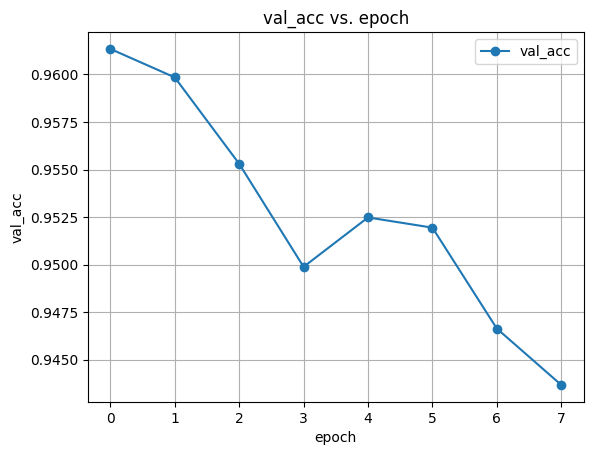

In [142]:
df_val_acc = df.dropna(subset=["val_acc"])

plt.plot(df_val_acc["epoch"], df_val_acc["val_acc"], label="val_acc", marker='o', linestyle='-')

# Labels and title
plt.xlabel("epoch")
plt.ylabel("val_acc")
plt.title("val_acc vs. epoch")
plt.legend()
plt.grid(True)
plt.show()

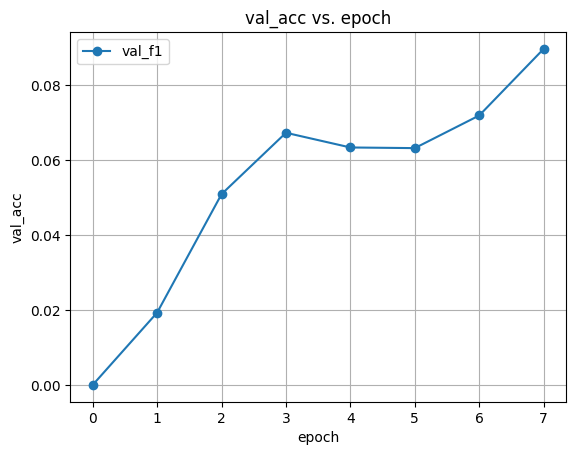

In [145]:
df_val_acc = df.dropna(subset=["val_f1"])

plt.plot(df_val_acc["epoch"], df_val_acc["val_f1"], label="val_f1", marker='o', linestyle='-')

# Labels and title
plt.xlabel("epoch")
plt.ylabel("val_acc")
plt.title("val_acc vs. epoch")
plt.legend()
plt.grid(True)
plt.show()

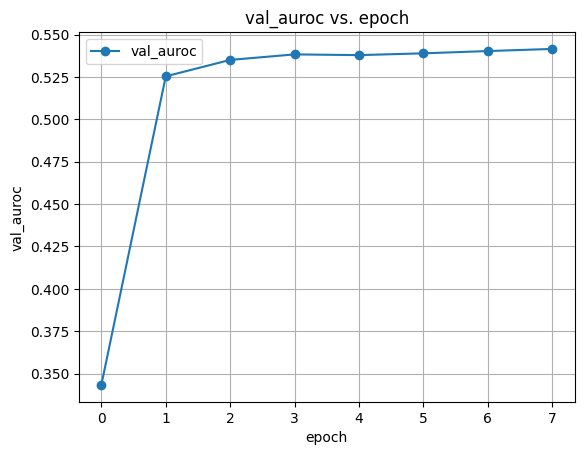

In [146]:
df_val_acc = df.dropna(subset=["val_auroc"])

plt.plot(df_val_acc["epoch"], df_val_acc["val_auroc"], label="val_auroc", marker='o', linestyle='-')

# Labels and title
plt.xlabel("epoch")
plt.ylabel("val_auroc")
plt.title("val_auroc vs. epoch")
plt.legend()
plt.grid(True)
plt.show()